# <font color='red'><ins>Práctica 3 FAA - Clasificación mediante Algoritmos Genéticos</ins></font>
## Alejandro Santorum Varela - alejandro.santorum@estudiante.uam.es
## José Manuel Chacón Aguilera - josem.chacon@estudiante.uam.es

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [3]:
# My modules
from Datos import Datos
import EstrategiaParticionado
import Clasificador

# External modules
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

# Init class Classifier
clasificador = Clasificador.Clasificador()

In [4]:
db_titanic = Datos('../ConjuntosDatos/titanic.data', allNominal = True)
n,m = db_titanic.datos.shape
print("Numero de ejemplos:", n,"| Numero de columnas:", m)

datosenc = Datos.encodeDatos(db_titanic.datos)
n,m = datosenc.shape
print("Numero de ejemplos:", n,"| Numero de columnas (ENCODE):", m)

Numero de ejemplos: 1046 | Numero de columnas: 4
Numero de ejemplos: 1046 | Numero de columnas (ENCODE): 22


In [5]:
print(db_titanic.datos[0])
print(datosenc[0])

[1. 1. 3. 1.]
[0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [21]:
# Entrenamiento. Consiste en sacar el individuo "ÓPTIMO".

    # - Definir la función/funciones de cruce
    # - Definir la mutación/mutaciones
    # - Definir la función/funciones de adaptación
    
    # ------------> Si nos calentamos, implementamos varias de estas y las consideramos hiper-parámetros del algoritmo.
    
# Clasificación. Consiste en comparar los genes de tu ejemplo con el individuo obtenido anteriormente, si tiene una codificación
# genética "parecida" codificas como superviviente.
    # Definir que es "parecido". 


In [22]:
# El INIT que tienes implementado no lo comprendo muy bien ni tampoco se usarlo, este solo es de prueba, 
# genera cadenas (sin sentido) para que pueda implementar primeras versiones tanto del cruze como de la mutación
npop = 100
population = []
max_rules = 5

for i in range(npop):
    # Creating a new individual, represented as a list of rules
    new_individual = []
    # The number of rules of the individual is chosen randomly,
    # between 1 (minimum number of rules) and 'self.max_rules'
    n_rules = random.randint(1, max_rules)
    for j in range(n_rules): # Creating 'n_rules' new rules
        # Asserting that new rule cannot have EVERY gene equal 0 or 1
        new_rule = []
        while sum(new_rule)==0 or sum(new_rule)==len(new_rule):
            # Creating a new rule as a random binary string of size 'feat_size' + 1 (predicted class)
            new_rule = random.choices([0,1], k = m)
        # Inserting new rule to the new individual
        new_individual.append(new_rule)
            
    # Inserting new individual to initial population
    population.append(new_individual)
    
print(population[3], len(population[3]))

[[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1], [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]] 4


In [23]:
# CRUCE EN UN PUNTO

# imput
P1 = population[0]
nr1 = len(P1)
P2 = population[2]
nr2 = len(P2)
print("\nPadre 1 ---> NR = %d\n" % (nr1))
print(P1)
print("\nPadre 2 ---> NR = %d\n" % (nr2))
print(P2)

# algoritmo
H1 = []
H2 = []
#cut1 = np.random.randint(0, nr1)
#cut2 = np.random.randint(0, nr2)
cut1 = 0
cut2 = 3

cp = 0
#cp = np.random.randint(1, m-1)
print("\nPunto de Corte Aleatorio ---> Rul. %d %d\n" % (cut1, cut2) +"\nPunto de Cruce Aleatorio ---> Pos. %d\n" % (cp))

H1 = P1[:cut1] + [P1[cut1][:cp] + P2[cut2][cp:]] + P2[cut2+1:]
H2 = P2[:cut2] + [P2[cut2][:cp] + P1[cut1][cp:]] + P1[cut1+1:]   

# output
print("\nHijo 1\n")
print(H1)
print("\nHijo 2\n")
print(H2)


Padre 1 ---> NR = 2

[[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]]

Padre 2 ---> NR = 5

[[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]]

Punto de Corte Aleatorio ---> Rul. 0 3

Punto de Cruce Aleatorio ---> Pos. 0


Hijo 1

[[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]]

Hijo 2

[[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,

In [24]:
def crossover_1point(ind1, ind2):
    # Debemos pensar/preguntar como cruzar dos individuos con un número diferente de reglas
    # Se dice en el ENUNCIADO que el punto de cruce debe ser el mismo para ambos padres, ¿qué pasa si uno tiene más reglas que otro?
    return child1, child2

In [25]:
def crossover_2point(ind1, ind2):
    # Mismas preguntas que arriba
    return child1, child2

In [26]:
# CRUCE UNIFORME
# IDEA -----> En lugar de ser 50% de probabilidad de tener el gen de un padre u otro, que esta cantidad
# escale dependiendo del fitness que tiene cada padre. Dando dominancia a los genes con mayor fitness.

# imput
P1 = population[0]
P2 = population[1]
print(P1)
print(P2)
minr = min(len(P1), len(P2))
# algoritmo
H1 = []
H2 = []
if(len(P1)>len(P2)):
    Htonto = P1[minr:]
else:
    Htonto = P2[minr:]

for j in range(minr):
        H1.append([])
        H2.append([])
        for i in range(len(P1[j])):
            rnd = np.random.randint(0, 2)
            if (rnd == 0):
                H1[j].append(P1[j][i])
            else:
                H1[j].append(P2[j][i])

            rnd = np.random.randint(0, 2)
            if (rnd == 0):
                H2[j].append(P1[j][i])
            else:
                H2[j].append(P2[j][i])
   


# output
print("\n\n")
print(H1)
print(H2)
print(Htonto)

[[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]]
[[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1], [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]]



[[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]]
[[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]]
[[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]]


In [27]:
# Cruce uniforme teniendo en cuenta individuos con varias reglas.
# Usa la implementación de arriba junto con la vista en teoría
def crossover_uniform(ind1, ind2):
    return child1, child2

In [28]:
mutar

<function __main__.mutar(IND, max_mute)>

In [29]:
# Mutación, permuta bit en posiciones aleatorias, acepta como hiper-parámetro el número máximo de bits que queremos mutar.
# No compruebo duplicidades, si muta dos veces el mismo gen es como si no lo hubiese hecho, lo dejamos así.

def mutar(IND, max_mute):
    print(IND)
    for j in range(len(IND)):
        n_mute = np.random.randint(1, max_mute+1)
        for i in range(n_mute):
            pos = np.random.randint(0, m)
            if(IND[j][pos] == 1):
                IND[j][pos] = 0
            else:
                IND[j][pos] = 1
    
    print(IND)
        
    

In [30]:
mutar (population[0], 3)

[[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]]
[[0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]]


# Primeras ejecuciones

In [22]:
db_titanic = Datos('../ConjuntosDatos/titanic.data', allNominal = True)
n,m = db_titanic.datos.shape
print("Numero de ejemplos:", n,"| Numero de columnas:", m)

datosenc = Datos.encodeDatos(db_titanic.datos)
n,m = datosenc.shape
print("Numero de ejemplos:", n,"| Numero de columnas (ENCODE):", m)

Numero de ejemplos: 1046 | Numero de columnas: 4
Numero de ejemplos: 1046 | Numero de columnas (ENCODE): 22


In [34]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

np.random.shuffle(datosenc)
strat_simple.creaParticiones(datosenc, None)

datostrain = datosenc[strat_simple.particiones[0].indicesTrain, :]
datostest = datosenc[strat_simple.particiones[0].indicesTest, :]

print(datostrain[:5, :])

[[0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [35]:
ga = Clasificador.AlgoritmoGenetico(
        n_population=20,
        max_rules=7,
        nepochs=20,
        cross_prob=0.7,
        bitflip_prob=1/20,
        add_rule_prob=0.3,
        elite_perc=0.05
)

In [36]:
ga.entrenamiento(datostrain, db_titanic.nominalAtributos, db_titanic.diccionario)

In [37]:
ga.best_solution

[[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]]

In [38]:
pred = ga.clasifica(datostest, db_titanic.nominalAtributos, db_titanic.diccionario)

In [39]:
clasificador.error(pred, datostest[:,-1])

0.3857142857142857

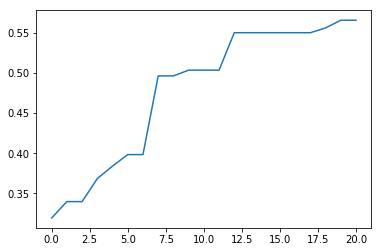

In [40]:
ntimes = len(ga.best_fitness_evol)

plt.plot(range(ntimes), ga.best_fitness_evol)

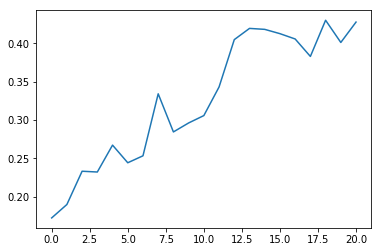

In [41]:
plt.plot(range(ntimes), ga.mean_fitness_evol)

# <font color='red'>1. Detalles de la implementación </font>

## <font color='blue'> 1.1 Generación población inicial </font>

El constructor del algoritmo 'AlgoritmoGenetico' recibe dos parámetros esenciales para la correcta generación de la población inicial: **n_population** y **max_rules**. El primero es el parámetro que indica el tamaño de la población inicial y que se mantendrá a lo largo de todas las épocas de evolución del algoritmo. El segundo indica el tamaño máximo de un individuo o solución,es decir, el número máximo de reglas de una solución. Este último parámetro es importante para evitar el sobreentrenamiento (*overfitting*) del modelo, ya que un número desorbitado de reglas produce que el algoritmo ajuste muy bien el conjunto de entrenamiento pero sea incapaz de generalizar el modelo para datos nuevos (conjunto de test). En esta práctica, se ha considerado que el número **máximo de reglas por individuo** tiene que oscilar entre **5 y 12**.

Con esto en mente, nos podemos centrar en la generación inicial del conjunto de individuos. Cada individuo es un conjunto de reglas, donde una regla es una cadena de ceros y unos que codifica una condición. El tamaño de la regla es constante, y se corresponde con el tamaño de un ejemplo del conjunto de datos **después** de ser codificado mediante *OneHotEncode* (incluyendo el bit de la clase), digamos **k** bits. Por lo tanto, para generar un nuevo individuo aleatorio, se sortea el número de reglas iniciales del individuo entre 1 y **max_rules** (incluidos) y se genera dicho número de reglas. Una regla aleatoria es una muestra de tamaño **k** de ceros y unos, es decir, extraer *k* bolas de una urna con un 1 y un 0 **con reemplazamiento**.

Como una regla donde *todos sus bits son nulos* es *inútil* debido a que **nunca se activa**, se ha incluido en la generación aleatoria de reglas que estas no puedan ser completamente nulas. Análogamente, una regla donde *todos sus bits son 1* es contraproducente, ya que **siempre se activa**, por lo que se ha añadido la condición de que una nueva regla aleatoria no pueda tener todo bits 1.

## <font color='blue'> 1.2 Mecanismo de cruce implementado </font>

## <font color='blue'> 1.3 Mecanismo de mutación implementado </font>

## <font color='blue'> 1.4 Mecanismo de clasificación implementado </font>

Al final de la fase de entrenamiento se escoge al mejor individuo de la población, es decir, la solución con mejor *fitness*. Durante la fase de clasificación se utilizará el mejor individuo obtenido en la fase de entrenamiento que codifica un conjunto de reglas.

Se dice que una regla se activa para un dato de clasificación cuando, para **cada atributo**, **alguno de sus bits está a 1** y **coincide** con el bit correspondiente de la regla. 

Cuando una regla se activa, esta predice una clase, que es el valor del k-ésimo bit (0 ó 1). Cuando se hayan comprobado entre todas las reglas cuales se activan, tendremos una lista (puede que vacía) de clases predichas, es decir, una lista de 'votos' para la clasificación de ese ejemplo. Finalmente, la clase predicha es la que recibe el mayor número de 'votos'. Es aquí donde surgen dos pequelas complicaciones: ¿qué pasa si el número de votos es igual para ambas clases?, ¿qué pasa si nunguna de las reglas se activa (lista de votos vacía)?.

Nosotros hemos considerado ambas casuísticas de diferente forma: si ninguna regla se activa (la lista de 'votos' está vacía) la función de clasificación devuelve **-1** para ese dato, y por consiguiente la función de cálculo de error va a considerar dicho ejemplo como **mal** clasificado **siempre**. Por otro lado, si el número de votos es idéntico, la clase predicha será **la clase con mayor probabilidad *a priori* **, la cual habrá sido **calculada en la fase de entrenamiento**, utilizando **únicamente** los datos de entrenamiento para **no generar sesgos** en la fase de clasificación.

# <font color='red'>2. Clasificación usando el modelo AlgoritmoGenetico </font>

## <font color='blue'> 2.1 Conjunto de datos titanic </font>

## <font color='blue'> 2.2 Conjunto de datos tic-tac-toe </font>

# <font color='red'>3. Análisis de resultados </font>

# <font color='red'>4. Evolución del fitness medio en la fase de entrenamiento </font>

# <font color='red'>5. Análisis ROC: NaiveBayes vs AlgoritmoGenetico </font>